In [1]:
import os
import sys
import pandas as pd
import numpy as np
import csv
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

sys.path.append('../src')
import utils
import settings
import logging

In [2]:
from importlib import reload
reload(settings)

<module 'settings' from '/Users/ew/Documents/open-image-search/search-model/src/settings.py'>

In [3]:
def create_cluster(X, cluster_model, cluster_num):
    """
    cluster features using the specified clusering model
    
    cluster_model:
        #kmeans
        #hierarchical
        #DBSCAN
    """
    logging.info("###############################################")
    logging.info("Clustering Model: {} \n".format(cluster_model))
    
    if cluster_model == "kmeans":
        #kmeans_model = KMeans(n_clusters=cluster_num, random_state=1).fit(X)
        #labels = kmeans_model.labels_
        labels = KMeans(n_clusters=cluster_num, random_state=1).fit_predict(X)
        logging.info("Cluster number: {} \n".format(cluster_num))
    elif cluster_model == "hierarchical":
        labels = AgglomerativeClustering(n_clusters=cluster_num).fit_predict(X)
    elif cluster_model == "DBSCAN":
        maxi_dis = 9
        min_samples = 8
        #db = DBSCAN(eps = maxi_dis, min_samples = min_samples).fit(X)
        #labels = db.labels_
        labels = DBSCAN(eps = maxi_dis, min_samples = min_samples).fit_predict(X)
        # Number of clusters in labels, ignoring noise if present
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        #print('Estimated number of clusters: %d' % n_clusters_)
        logging.info("eps= {}, min_samples= {} \n".format(maxi_dis, min_samples))
        logging.info("Estimated number of clusters: {} \n".format(n_clusters_))
        
    else:
        #print("Clustering model not recognized")
        logging.info("Clustering model not recognized")
    
    #print("Total number of features: ", len(labels))
    #print(Counter(labels))
    logging.info("Total number of features: {} \n".format(len(labels)))
    logging.info(Counter(labels))
    
    return labels
    
def evaluate_cluster(X, labels, eval_metrics):
    """
    evaluate cluster results based on between-clusters and within-cluster dispersion
    
    eval_metrics:    
        #silhouette: mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)
        #davies_bouldin: average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances
        #all: print all three scores above
    """
    if eval_metrics == "silhouette":
        score = metrics.silhouette_score(X, labels, metric='cosine')#higher the better
        print("Silhouette Score: ", score)
        logging.info("Silhouette Score: {} \n".format(score))
    elif eval_metrics == "calinski_harabasz":
        score = metrics.calinski_harabasz_score(X, labels)#higher the better
        print("Calinski-Harabasz Score: ", score)
        logging.info("Calinski-Harabasz Score: {} \n".format(score))
    elif eval_metrics == "davies_bouldin":
        score = metrics.davies_bouldin_score(X, labels) #lower the better
        print("Davies-Bouldin Score: ", score)
        logging.info("Davies-Bouldin Score: {} \n".format(score))
    elif eval_metrics == "all":
        score = metrics.silhouette_score(X, labels, metric='cosine')
        logging.info("Silhouette Score: {} \n".format(score))
        score = metrics.calinski_harabasz_score(X, labels)
        logging.info("Calinski-Harabasz Score: {} \n".format(score))
        score = metrics.davies_bouldin_score(X, labels)
        logging.info("Davies-Bouldin Score: {} \n".format(score))     
    else:
        logging.info("Evaluation Metrics not recognized")
    

In [4]:
def find_optimal_cluster_num(X, cluster_model, eval_metrics):
    """
    Generate Elbow plots to find optimal cluster number
    
    cluster_model:
        #kmeans
        #hierarchical
    eval_metrics:
        #distrotion: sum of squared distances from each point to its assigned center
        #silhouette: mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)
        #calinski_harabasz: ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)
        #all: print all three elbow graphs above
    """
    if cluster_model == "kmeans":
        model = KMeans()
    elif cluster_model == "hierarchical":
        model = AgglomerativeClustering()
    else:
        print("Clustering model not recognized")
    
    img_path = os.path.join(settings.cluster_fldr_path, 'Elbow_'+settings.model_name+'_'+eval_metrics+'.png')
    
    if eval_metrics == "distrotion":
        visualizer = KElbowVisualizer(model, k=(2,8))
        visualizer.fit(np.array(X))
        visualizer.show(outpath=img_path)
    elif eval_metrics == "silhouette":
        visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette')
        visualizer.fit(np.array(X))
        visualizer.show(outpath=img_path)
    elif eval_metrics == "calinski_harabasz":
        visualizer = KElbowVisualizer(model, k=(2,8), metric='calinski_harabasz')
        visualizer.fit(np.array(X))
        visualizer.show(outpath=img_path)
    elif eval_metrics == "all":
        
        visualizer = KElbowVisualizer(model, k=(2,8))
        visualizer.fit(np.array(X))
        visualizer.show()
        
        visualizer_s = KElbowVisualizer(model, k=(2,8), metric='silhouette')
        visualizer_s.fit(np.array(X))
        visualizer_s.show()
        
        visualizer_ch = KElbowVisualizer(model, k=(2,8), metric='calinski_harabasz')
        visualizer_ch.fit(np.array(X))
        visualizer_ch.show()

     
    else:
        print("Evaluation Metrics not recognized") 
        
    visualizer.fit(np.array(X))
    visualizer.show() 

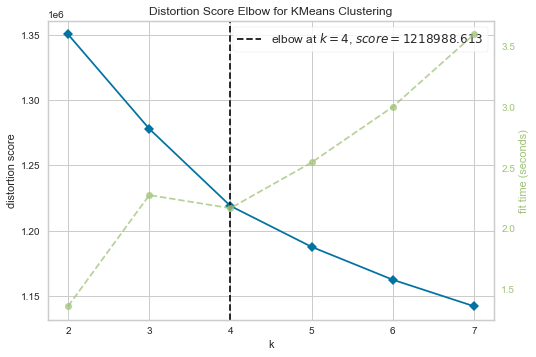

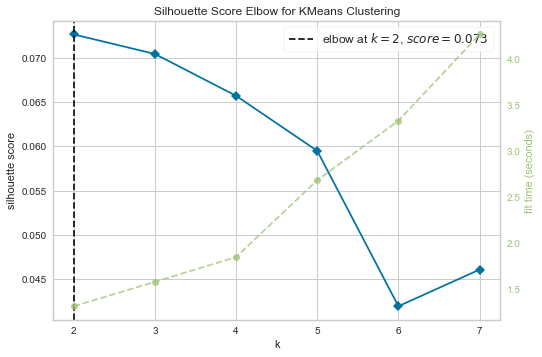

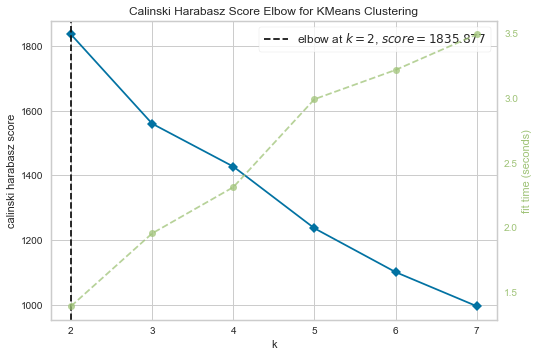

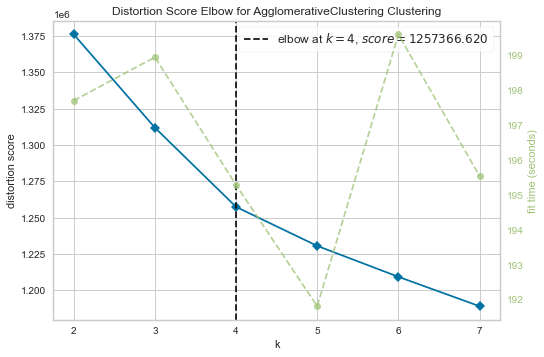

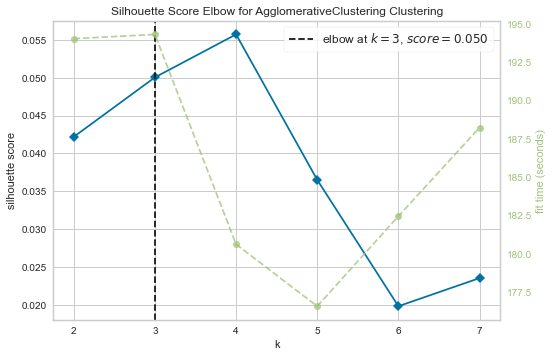

In [ ]:
def main():
    
    fpath = os.path.join(settings.cluster_fldr_path, 'cluster_notes_'+settings.model_name+'.log')
    # save clustering summary
    logging.basicConfig(level=logging.INFO, filename=fpath, filemode='w', force=True, format='%(message)s')
    logging.info("Feature extractor: {} \n".format(settings.model_name))
    logging.info("Image dimension: {} \n".format(settings.img_min_dimension))
        
    _, features_list  = utils.load_features(fpath=settings.features_fpath)
    
    for cluster_model in ["kmeans",'hierarchical','DBSCAN']:
        
        labels = create_cluster(features_list, cluster_model, 3)
    
        evaluate_cluster(features_list, labels, "all")
        
        
        if cluster_model == 'DBSCAN':
            continue 
        else:
            find_optimal_cluster_num(features_list, cluster_model, "all")
    
    returns

if __name__ == '__main__':

    main()